In [52]:
import copy
from functools import partial

from scipy.stats import norm, chi2
from scipy.optimize import minimize
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt

In [53]:
%matplotlib inline

In [54]:
error = norm(0.0, 1.0)

In [55]:
beta = np.array([1., 2., -3., 4.])

In [56]:
x = np.arange(0.0, 1.0, .01)
x_shape = (len(x), 1)
x = np.reshape(x, x_shape)

In [57]:
X_input = np.concatenate([np.ones(x_shape), x, x**2, x**3], axis=1)

In [58]:
Y = np.matmul(X_input, beta)

In [59]:
Y_with_errors = Y + error.rvs(len(Y))

In [60]:
regression = linear_model.LinearRegression(fit_intercept=False)
regression.fit(X_input, Y_with_errors)
Y_hat = regression.predict(X_input)

In [61]:
beta_hat = copy.copy(regression.coef_)
beta_hat

array([ 1.14419934,  2.48635143, -6.76239742,  7.46126203])

In [62]:
beta

array([ 1.,  2., -3.,  4.])

In [63]:
N, p = X_input.shape
y_var_hat = 1. / (N - p - 1) * np.sum((Y_with_errors - Y_hat) ** 2)
beta_hat_var = np.linalg.inv(np.matmul(X_input.T, X_input)) * y_var_hat

In [64]:
x_var = np.array([
    np.matmul(np.matmul(x_in, beta_hat_var), x_in.T)
    for x_in in X_input
])

In [65]:
percentile_975 = norm.ppf(.975)

Y_hat_lower = np.array([
    value - percentile_975 * np.sqrt(x_var[index])
    for index, value in enumerate(Y_hat)
])

Y_hat_upper = np.array([
    value + percentile_975 * np.sqrt(x_var[index])
    for index, value in enumerate(Y_hat)
])

In [66]:
Y_hat_upper.shape

(100,)

In [67]:
def check_beta_in_confidence_set(test_beta):
    chi_percentile_95 = chi2(p).ppf(.95)
    beta_diff = np.reshape(beta_hat - test_beta, (p, 1))
    Xt_X = np.matmul(X_input.T, X_input)
    beta_Xt_X = np.matmul(beta_diff.T, Xt_X)
    lhs = np.matmul(beta_Xt_X, beta_diff)
    rhs = y_var_hat * chi_percentile_95
    return lhs < rhs

In [68]:
# do a grid search for available betas in confidence interval
all_test_betas = np.array([
    [
        row + mod
        for mod in np.arange(-10 * y_var_hat, 10. * y_var_hat, y_var_hat / 1000.)
    ]
    for row in beta_hat
]).T
test_betas = np.array([
    test_beta 
    for test_beta in all_test_betas
    if check_beta_in_confidence_set(test_beta)
])

In [69]:
# for each X find a beta in the confidence set that minimizes Y
Y_confidence_lower = [
    min(np.matmul(x_in, beta.T) for beta in test_betas)
    for x_in in X_input
]

# for each X find a beta in the confidence set that minimizes Y
Y_confidence_upper = [
    max(np.matmul(x_in, beta.T) for beta in test_betas)
    for x_in in X_input
]

Y_confidence_lower = np.array(Y_confidence_lower)

Y_confidence_upper = np.array(Y_confidence_upper)

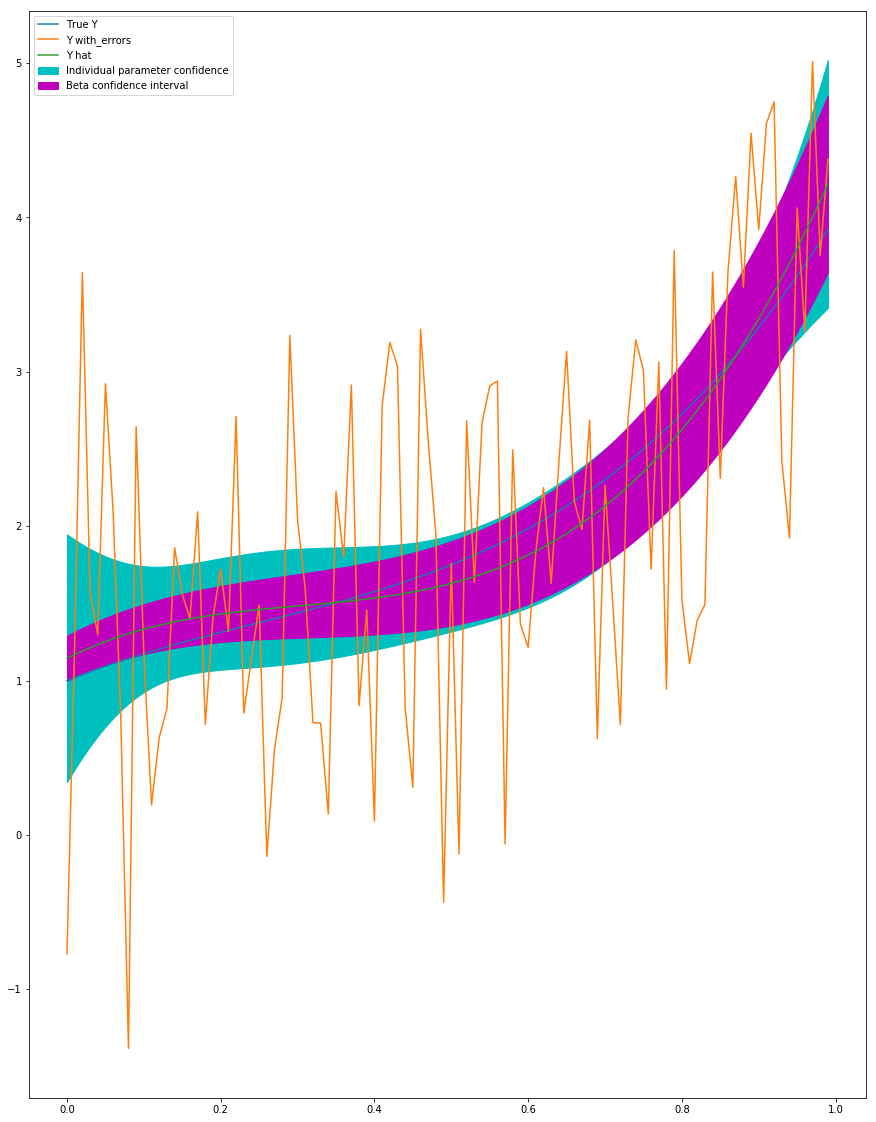

In [70]:
plt.figure(figsize=(15, 20))
x_one_dim = np.reshape(x, Y_confidence_lower.shape)
display_len = int(len(x_one_dim))
plt.fill_between(x_one_dim[:display_len], 
                 Y_hat_lower[:display_len], 
                 Y_hat_upper[:display_len], 
                 label='Individual parameter confidence',
                 color='c')
plt.fill_between(x_one_dim[:display_len], 
                 Y_confidence_lower[:display_len], 
                 Y_confidence_upper[:display_len], 
                 label='Beta confidence interval',
                 color='m')
plt.plot(x[:display_len], Y[:display_len], label='True Y')
plt.plot(x[:display_len], Y_with_errors[:display_len], label='Y with_errors')
plt.plot(x[:display_len], Y_hat[:display_len], label='Y hat')
plt.legend()